# RAPIDS & Scanpy Single-Cell RNA-seq Workflow on PFC cells

Copyright (c) 2020, NVIDIA CORPORATION.

Licensed under the Apache License, Version 2.0 (the "License") you may not use this file except in compliance with the License. You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0 

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

This notebook demonstrates a single-cell RNA analysis workflow that begins with preprocessing a count matrix of size `(n_gene, n_cell)` and results in a visualization of the clustered cells for further analysis.

For demonstration purposes, we use a dataset of 1.3 M brain cells with Unified Virtual Memory to oversubscribe GPU memory.

## Import requirements

In [1]:
import numpy as np
import scanpy as sc
import anndata
import scipy.io
import scipy.sparse

import time
import os, wget


import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import cuml
import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import rmm

from rmm.allocators.cupy import rmm_cupy_allocator
import cupy
cupy.cuda.set_allocator(rmm_cupy_allocator)
from scipy import sparse
import gc
import cupy as cp
gc.collect()
cp.get_default_memory_pool().free_all_blocks()

We use the RAPIDS memory manager to enable Unified Virtual Memory management, which allows us to oversubscribe the GPU memory.

In [2]:
import rmm
rmm.reinitialize(managed_memory=True)
from rmm.allocators.cupy import rmm_cupy_allocator
import cupy
cupy.cuda.set_allocator(rmm_cupy_allocator)

## Input data

In the cell below, we provide the path to the sparse `.h5ad` file containing the count matrix to analyze. Please see the README for instructions on how to download the dataset we use here.

To run this notebook using your own dataset, please see the README for instructions to convert your own count matrix into this format. Then, replace the path in the cell below with the path to your generated `.h5ad` file.

In [ ]:

mtx_path=r"/data/human_MDD_PFC/GSE144136_GeneBarcodeMatrix_Annotated.mtx"
cell_name_path=r"/data/human_MDD_PFC/GSE144136_CellNames.csv"
gene_name_path=r"/data/human_MDD_PFC/GSE144136_GeneNames.csv"

genes = pd.read_csv(gene_name_path,index_col=0)
cells = pd.read_csv(cell_name_path,index_col=0)
adata=sc.read_mtx(mtx_path)
adata=adata.T
adata.obs_names = cells.x.values
adata.var_names = genes.x.values
adata.X=sparse.csr_matrix(adata.X)

celltype_df=pd.DataFrame(cells.x.str.split(".",expand=True))
barcode_df=celltype_df.iloc[:,1].str.split("_",expand=True)
barcode_df2=pd.concat([celltype_df.iloc[:,0],barcode_df],axis=1)
barcode_df2=barcode_df2.set_axis(["celltype","subject","case_control","batch","barcode"],axis="columns")
b_df3=barcode_df2.copy()
b_df3.index=adata.obs.index
obs_col=["celltype","subject","case_control","batch","barcode"]
adata.obs["label"]=b_df3["case_control"]
adata.write("/data/human_MDD_PFC/merged_data.h5ad")
#arr = scipy.io.mmread(mtx_path).tocsr()

In [54]:
adata.write("/data/human_MDD_PFC/merged_data.h5ad")

In [62]:
adata_control=adata[adata.obs["label"]=="Control"]
adata_suicide=adata[adata.obs["label"]=="Suicide"]

In [63]:
adata_control.write("/data/human_MDD_PFC/merged_control_data.h5ad")
adata_suicide.write("/data/human_MDD_PFC/merged_suicide_data.h5ad")

preprocess_in_bulk
['CX3CR1', 'CLDN5', 'GLUL', 'NDRG2', 'PCDH15', 'PLP1', 'MBP', 'SATB2', 'SLC17A7', 'SLC17A6', 'GAD2', 'GAD1', 'SNAP25', 'HTR1A', 'HTR1B', 'HTR1D', 'HTR1E', 'HTR2A', 'HTR2B', 'HTR2C', 'HTR3A', 'HTR4', 'HTR5A', 'HTR6', 'HTR7', 'DRD1', 'DRD2', 'DRD3', 'DRD4', 'DRD5', 'HRH1', 'HRH2', 'HRH3', 'CHRM1', 'CHRM2', 'CHRM3', 'CHRM4', 'CHRM5', 'ADRA1A', 'ADRA1B', 'ADRA2A', 'ADRA2B', 'ADRA2C', 'ADRB1', 'ADRB2']
perform regression
perform scale
float32
Total Preprocessing time: 39.809627294540405
shape of adata: (35184, 29432)
shape of adata: (35184, 29432)
perform PCA
10
t-sne
UMAP
[2025-04-05 09:13:05.771] [CUML] [info] build_algo set to brute_force_knn because random_state is given
UMAP louvain


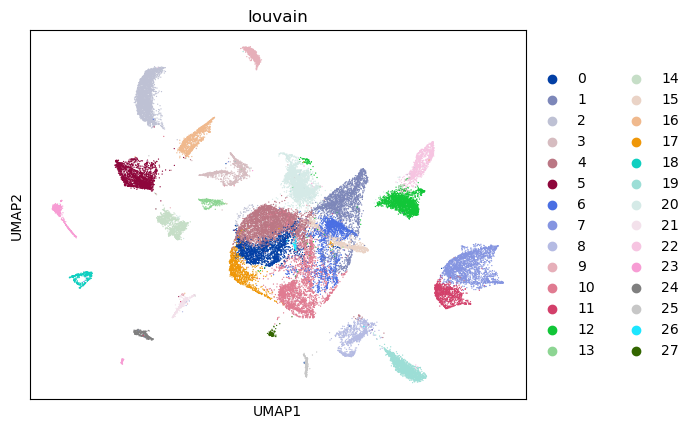

UMAP leiden


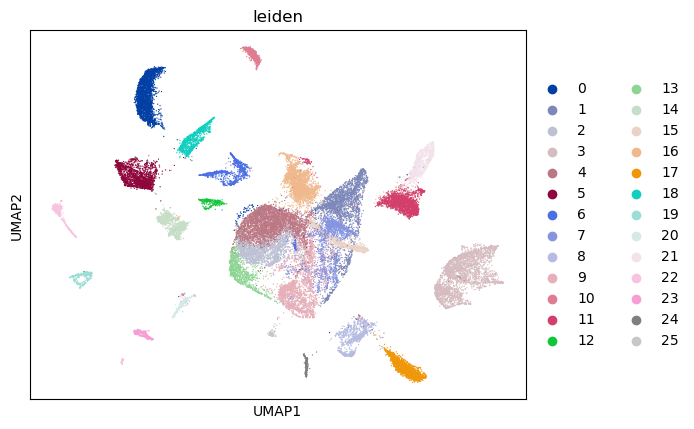

calc drug response
clz selective cells
# of clz selective cells: is_clz_selective
False    31217
True      3967
Name: count, dtype: int64


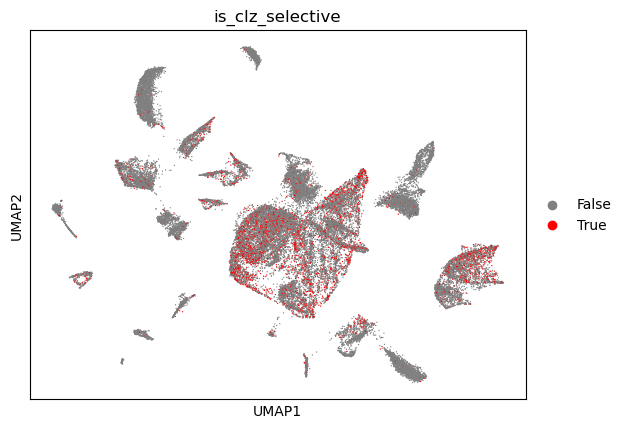

In [64]:
import calculation_tool as ct
file_path="/data/human_MDD_PFC/merged_control_data.h5ad"
adata,GPCR_df=ct.preprocess_adata_in_bulk(file_path,label=None,is_gpu=False)
GPCR_df.to_csv("/data/human_MDD_PFC/combined_data_GPCR_df.csv")

Drug concentration: 0.001
clz selective cells
# of clz selective cells: is_clz_selective
False    34503
True       681
Name: count, dtype: int64


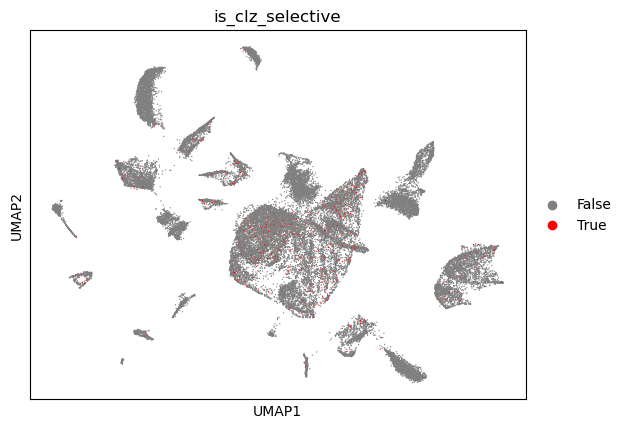

Drug concentration: 0.01
clz selective cells
# of clz selective cells: is_clz_selective
False    34503
True       681
Name: count, dtype: int64


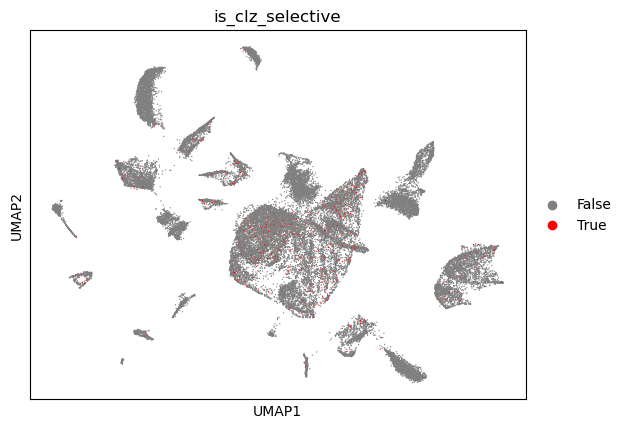

Drug concentration: 0.1
clz selective cells
# of clz selective cells: is_clz_selective
False    34503
True       681
Name: count, dtype: int64


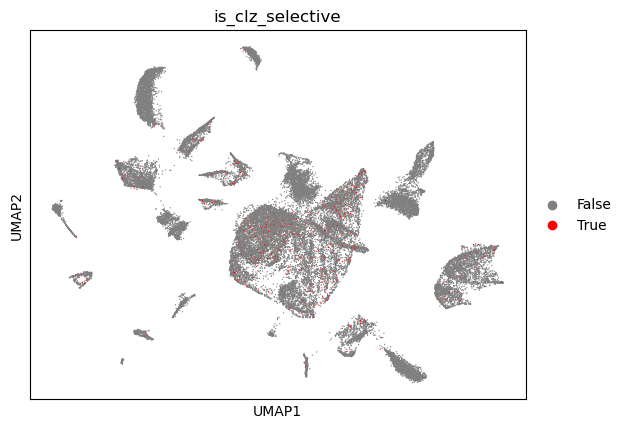

Drug concentration: 1
clz selective cells
# of clz selective cells: is_clz_selective
False    34481
True       703
Name: count, dtype: int64


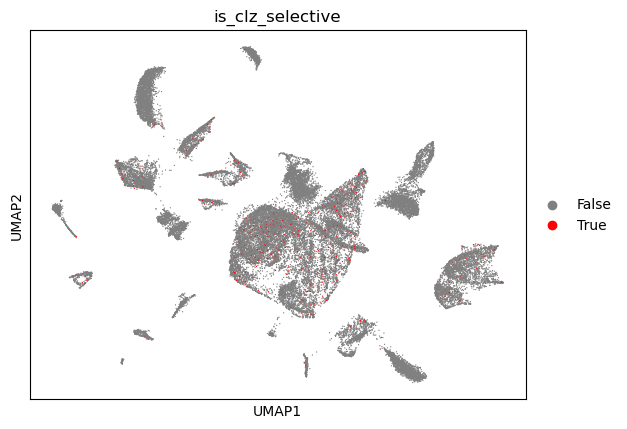

Drug concentration: 1.5848931924611136
clz selective cells
# of clz selective cells: is_clz_selective
False    34445
True       739
Name: count, dtype: int64


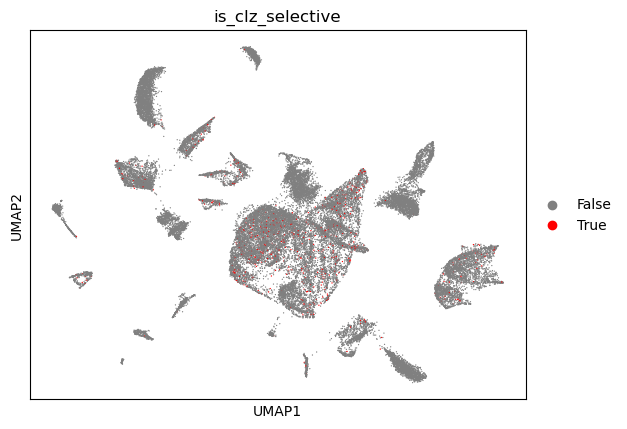

Drug concentration: 2.2387211385683394
clz selective cells
# of clz selective cells: is_clz_selective
False    34374
True       810
Name: count, dtype: int64


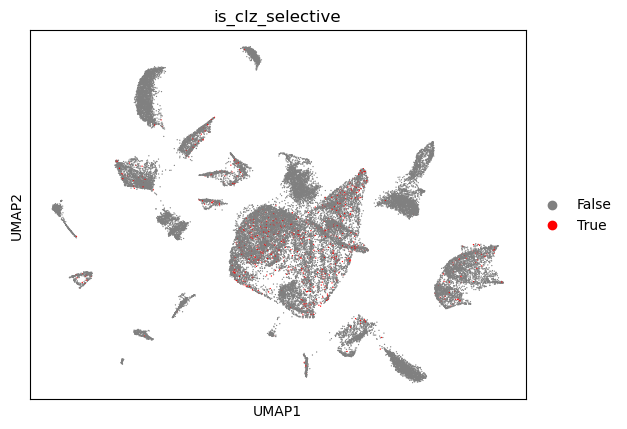

Drug concentration: 3.1622776601683795
clz selective cells
# of clz selective cells: is_clz_selective
False    33881
True      1303
Name: count, dtype: int64


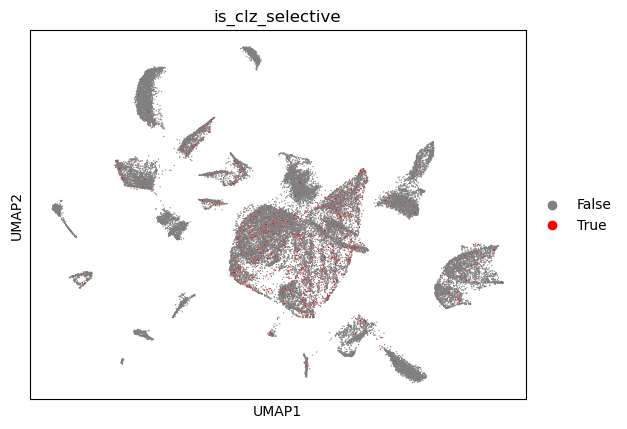

Drug concentration: 5.623413251903491
clz selective cells
# of clz selective cells: is_clz_selective
False    33804
True      1380
Name: count, dtype: int64


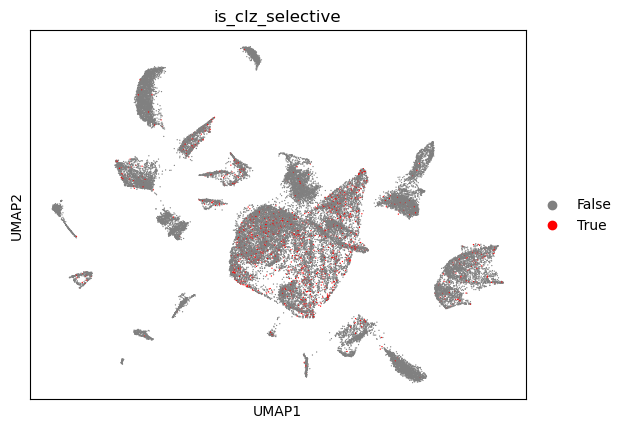

Drug concentration: 10
clz selective cells
# of clz selective cells: is_clz_selective
False    33608
True      1576
Name: count, dtype: int64


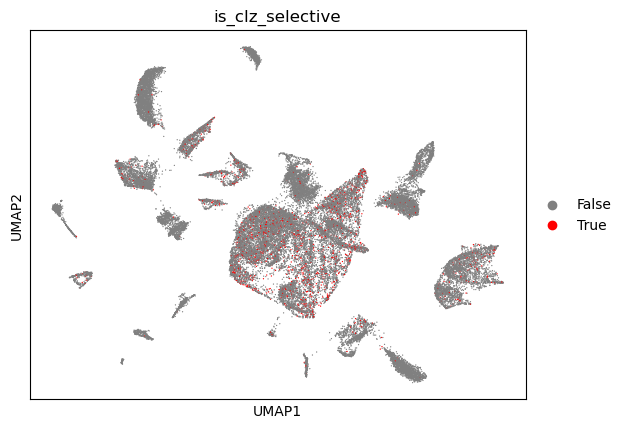

Drug concentration: 31.622776601683793
clz selective cells
# of clz selective cells: is_clz_selective
False    33234
True      1950
Name: count, dtype: int64


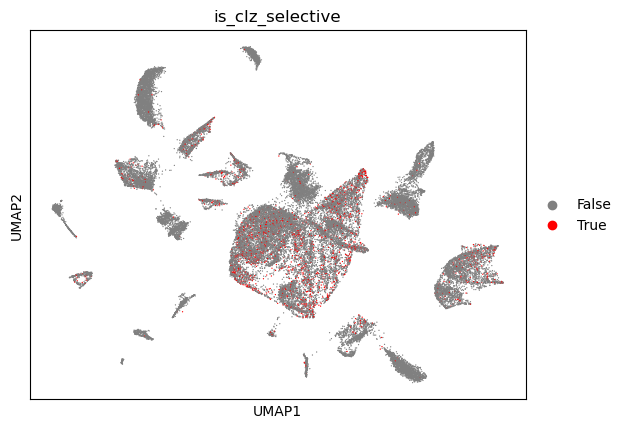

Drug concentration: 100
clz selective cells
# of clz selective cells: is_clz_selective
False    31518
True      3666
Name: count, dtype: int64


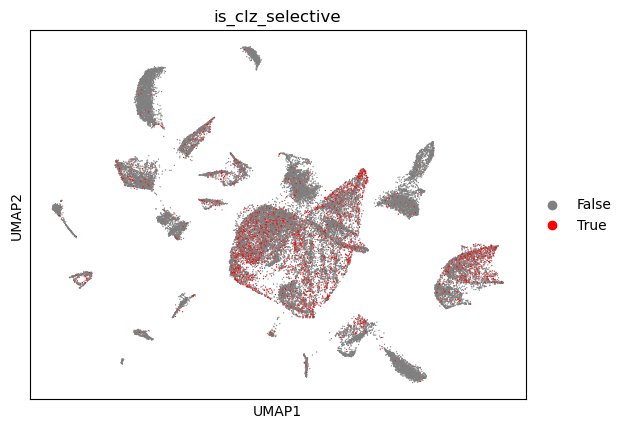

Drug concentration: 316.22776601683796
clz selective cells
# of clz selective cells: is_clz_selective
False    31252
True      3932
Name: count, dtype: int64


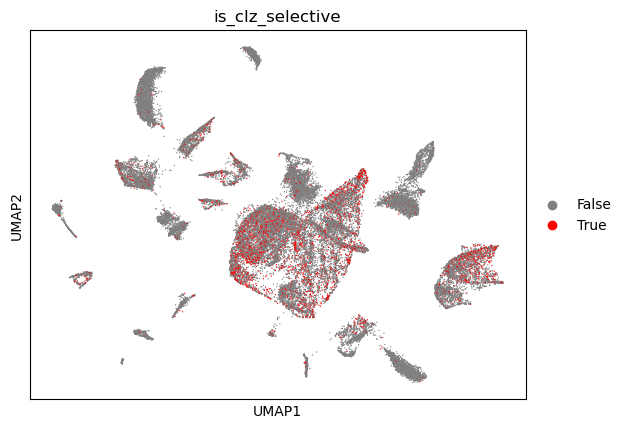

Drug concentration: 1000
clz selective cells
# of clz selective cells: is_clz_selective
False    31002
True      4182
Name: count, dtype: int64


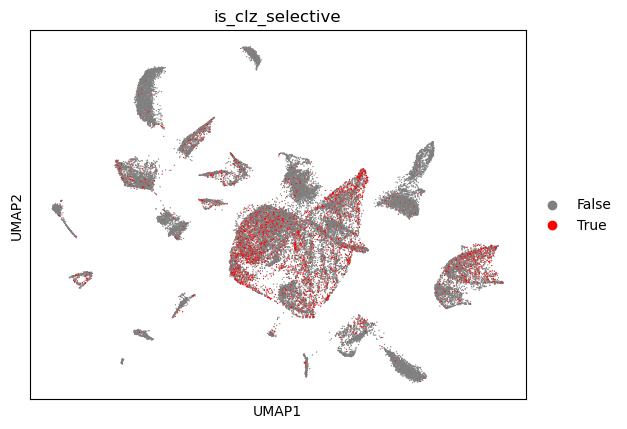

Drug concentration: 10000
clz selective cells
# of clz selective cells: is_clz_selective
False    31633
True      3551
Name: count, dtype: int64


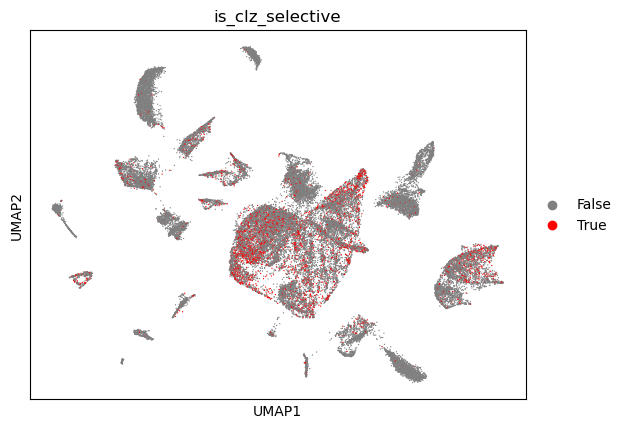

Drug concentration: 100000
clz selective cells
# of clz selective cells: is_clz_selective
False    32503
True      2681
Name: count, dtype: int64


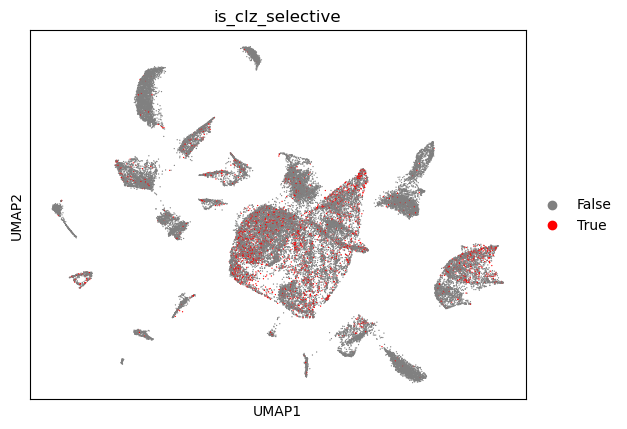

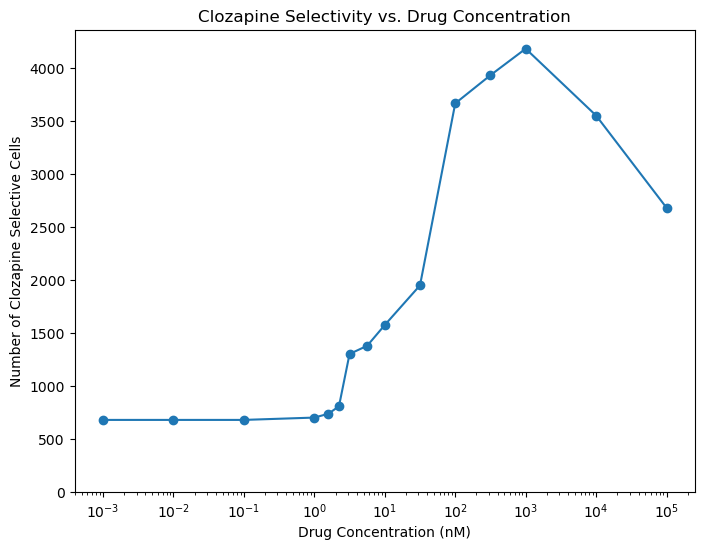

In [65]:
D_R_mtx,GPCR_type_df,drug_list,GPCR_list=ct.load_parameters()
params=ct.set_parameters_for_preprocess(GPCR_list)
import calculation_tool as ct
ct.drug_titeration(adata, GPCR_df, GPCR_type_df, drug_list, D_R_mtx)

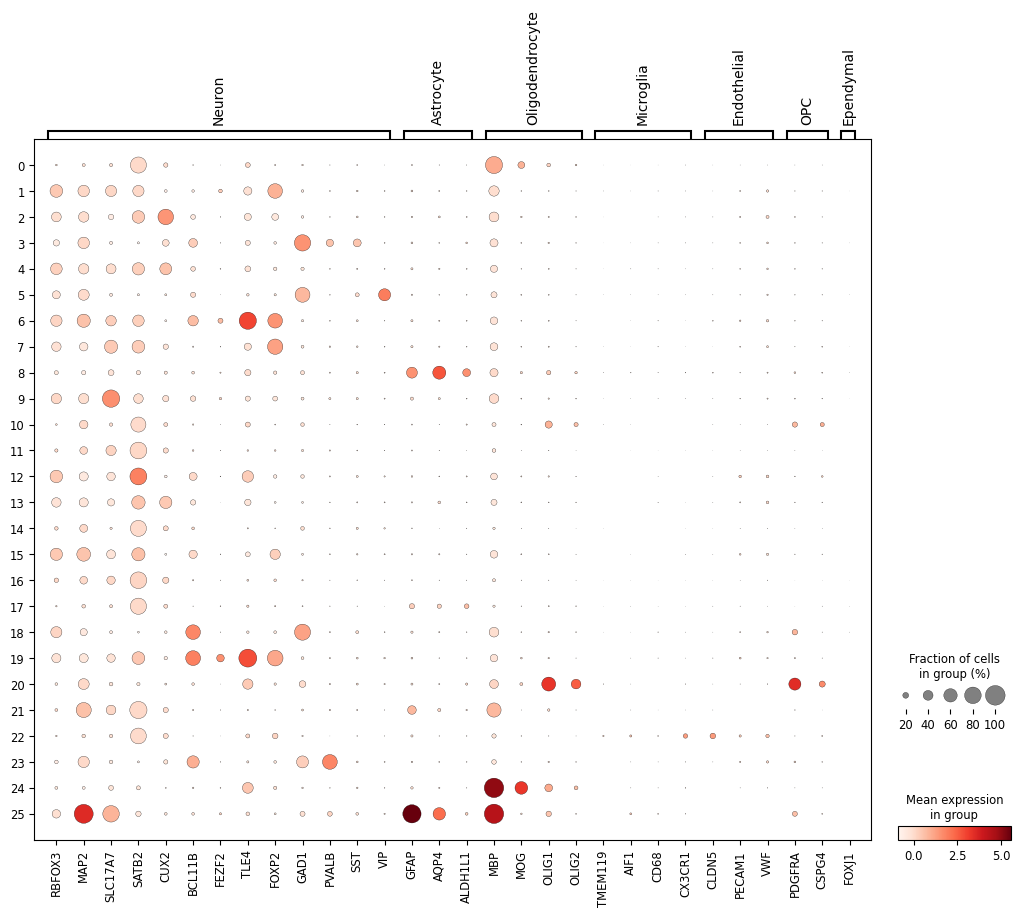

In [66]:
marker_genes_dict = {
    "Neuron": ["RBFOX3", "MAP2", "SLC17A7", "SATB2", "CUX2","BCL11B", "FEZF2","TLE4", "FOXP2","GAD1","PVALB","SST","VIP"],
    "Astrocyte": ["GFAP", "AQP4", "ALDH1L1"],
    "Oligodendrocyte": ["MBP", "MOG", "OLIG1", "OLIG2"],
    "Microglia": ["TMEM119", "AIF1", "CD68", "CX3CR1"],
    "Endothelial": ["CLDN5", "PECAM1", "VWF"],
    "OPC": ["PDGFRA", "CSPG4"],
    "Ependymal": ["FOXJ1"]
}
sc.pl.dotplot(adata, marker_genes_dict, "leiden")

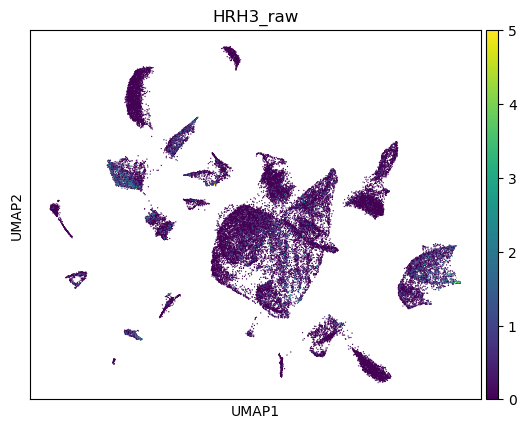

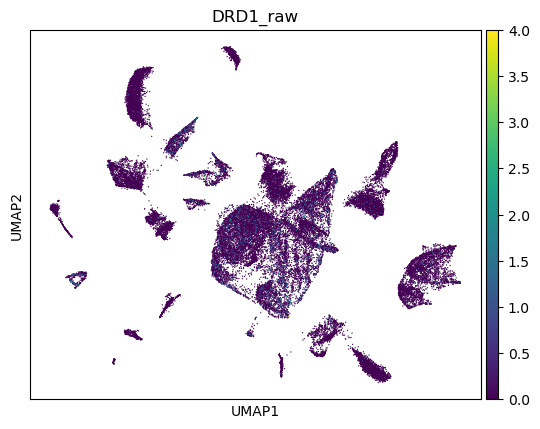

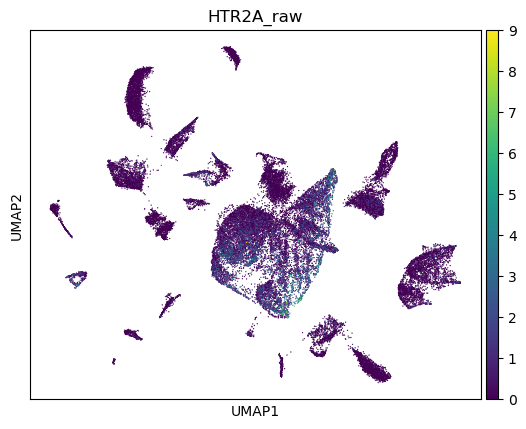

KeyError: 'Could not find key ADRA2_raw in .var_names or .obs.columns.'

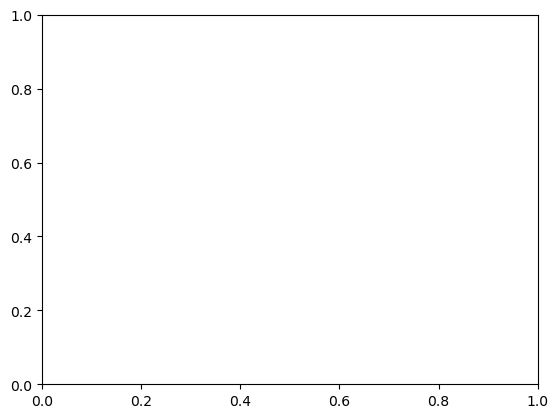

In [ ]:
sc.pl.umap(adata, color=["HRH3_raw"])
sc.pl.umap(adata, color=["DRD1_raw"])
sc.pl.umap(adata, color=["HTR2A_raw"])

In [67]:
GPCR_adata=anndata.AnnData(X=GPCR_df)
GPCR_adata_norm=sc.pp.normalize_total(GPCR_adata,target_sum=1e4,inplace=False)['X']
GPCR_adata_norm_df=pd.DataFrame(GPCR_adata_norm,columns=GPCR_adata.var.index)

In [73]:
#import calculation_tool as ct

drug_conc=10**3
results_df_sorted,all_responses=ct.sim_inhibit_pattern(adata,GPCR_adata_norm_df,GPCR_type_df,drug_conc,n_pattern=10000)

Pattern_1: {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1E_raw': True, 'HTR2A_raw': True, 'HTR2B_raw': False, 'HTR2C_raw': True, 'HTR3A_raw': False, 'HTR4_raw': True, 'HTR5A_raw': True, 'HTR6_raw': True, 'HTR7_raw': True, 'DRD1_raw': True, 'DRD2_raw': False, 'DRD3_raw': True, 'DRD4_raw': True, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': True, 'HRH3_raw': False, 'CHRM1_raw': True, 'CHRM2_raw': False, 'CHRM3_raw': False, 'CHRM4_raw': False, 'CHRM5_raw': True, 'ADRA1A_raw': True, 'ADRA1B_raw': False, 'ADRA2A_raw': False, 'ADRA2B_raw': True, 'ADRA2C_raw': True, 'ADRB1_raw': True, 'ADRB2_raw': False}
Pattern_2: {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1D_raw': False, 'HTR1E_raw': False, 'HTR2A_raw': False, 'HTR2B_raw': False, 'HTR2C_raw': True, 'HTR3A_raw': True, 'HTR4_raw': True, 'HTR5A_raw': False, 'HTR6_raw': True, 'HTR7_raw': False, 'DRD1_raw': True, 'DRD2_raw': False, 'DRD3_raw': False, 'DRD4_raw': True, 'DRD5_raw': False, 'HRH1_raw': False, 'HRH2_raw': Fal

Simulating drug responses: 100%|██████████| 10000/10000 [05:04<00:00, 32.87it/s]

      pattern_name                                            pattern  \
8599  Pattern_8600  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
6576  Pattern_6577  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
8998  Pattern_8999  {'HTR1A_raw': False, 'HTR1B_raw': False, 'HTR1...   
1154  Pattern_1155  {'HTR1A_raw': False, 'HTR1B_raw': True, 'HTR1D...   
8595  Pattern_8596  {'HTR1A_raw': True, 'HTR1B_raw': False, 'HTR1D...   

             diff  
8599  3311.342429  
6576  3311.096625  
8998  3309.963498  
1154  3309.352160  
8595  3307.310045  


In [74]:
dir="/data/human_MDD_PFC"
results_df_sorted.to_csv(os.path.join(dir,"results_df_sorted.csv"))
all_responses.to_csv(os.path.join(dir,"all_responses.csv"))

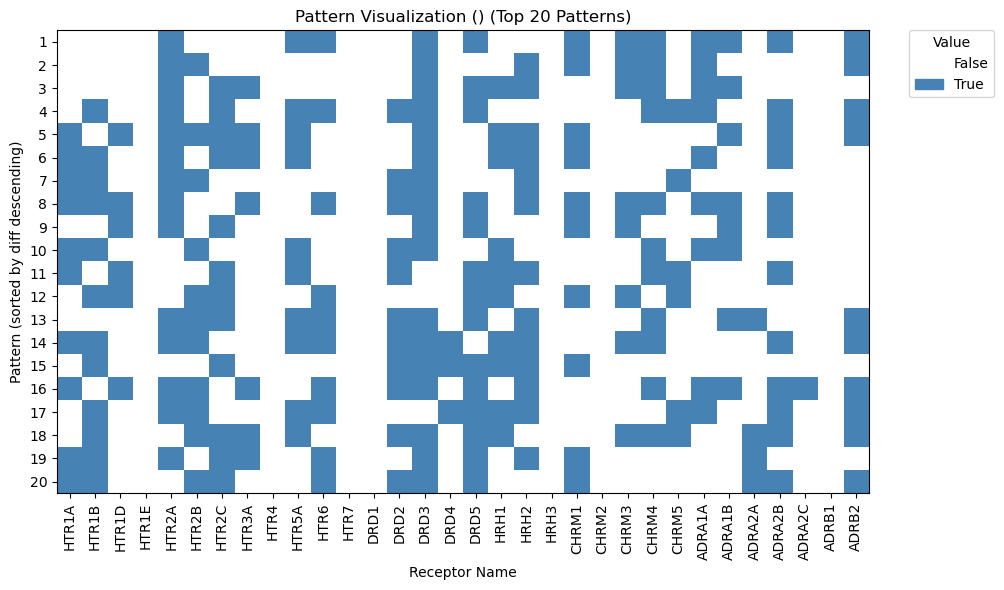

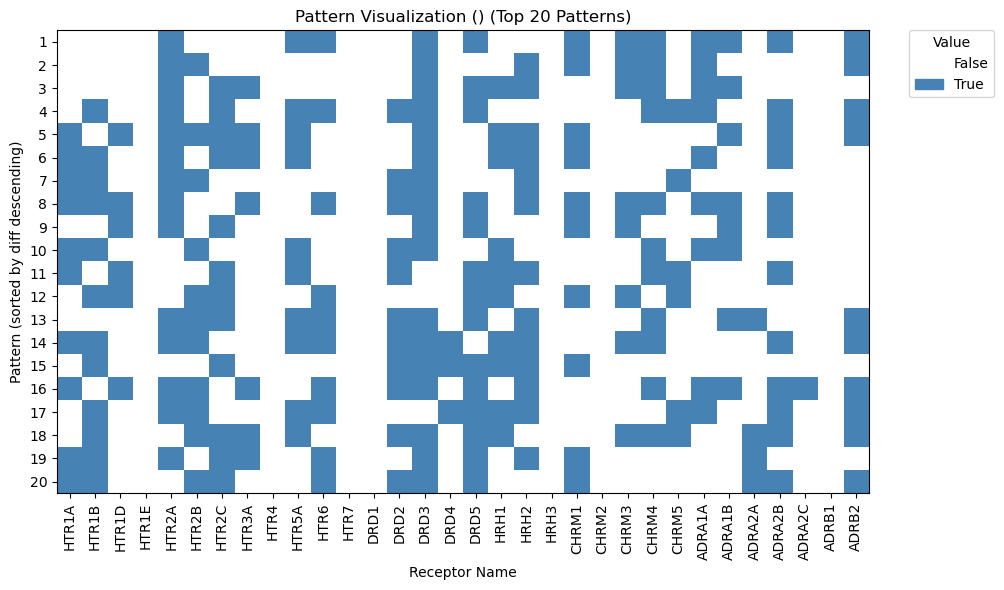

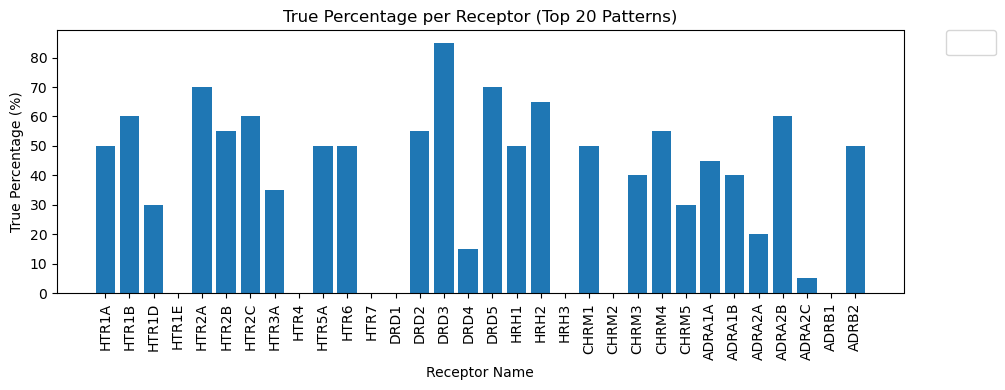

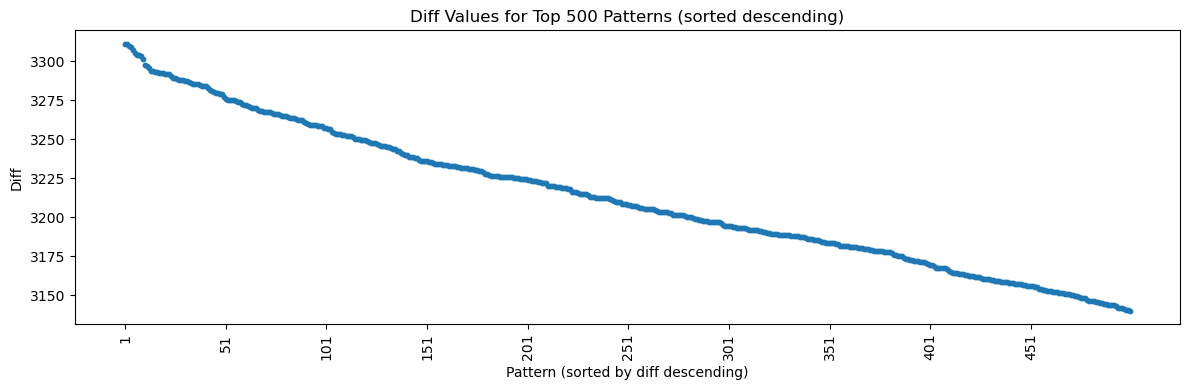

In [75]:
ct.visualize_patterns(results_df_sorted, top_n=20, top_n_for_heatmap=20, scatter_n=500)